Импортируем библиотеки, используем GPU (если доступна), масштабируем изображения к размеру 224 px

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import colors, pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
sns.set_style(style="darkgrid")

import random
import pickle
import copy
import time
from pathlib import Path
from multiprocessing.pool import ThreadPool

from skimage import io
from PIL import Image
from tqdm import tqdm, tqdm_notebook, trange

import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

train_on_gpu = torch.cuda.is_available()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
print(f"Training on {DEVICE}")

N_CLASSES = 42

Training on cuda


Подготовка данных

In [ ]:
!pip install gdown
!gdown --id 14BSPVM_IKClPIV3jMpJyEj1of3QfxCLy

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14BSPVM_IKClPIV3jMpJyEj1of3QfxCLy
To: /content/journey-springfield.zip
100% 546M/546M [00:24<00:00, 22.6MB/s]


In [ ]:
!unzip -q /content/journey-springfield.zip

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Написание модуля Dataset для данных

In [ ]:
train_val_files = list(TRAIN_DIR.rglob("*.jpg"))
test_files = list(TEST_DIR.rglob("*.jpg"))

ALL_LABELS = [path.parent.name for path in train_val_files]

LE = LabelEncoder()
print(train_val_files)
LE.fit(ALL_LABELS)

[PosixPath('train/simpsons_dataset/martin_prince/pic_0022.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0013.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0062.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0045.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0001.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0018.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0050.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0060.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0041.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0069.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0014.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0056.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0030.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0047.jpg'), PosixPath('train/simpsons_dataset/martin_prince/pic_0016.jpg'), PosixPath('train/simpsons_dataset/marti

LabelEncoder()

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, transforms, mode):
        super().__init__()

        if mode not in DATA_MODES:
            raise ValueError(f"Incorrect mode {mode} ! \n Please put one of the following data modes: {DATA_MODES}")
        self.mode = mode

        self.files = files
        self.transforms = transforms
        self.labels = [path.parent.name for path in files]

    def __len__(self):
        return len(self.files)


    def __getitem__(self, index):
        img = Image.open(self.files[index])
        img_t = self.transforms(img)

        if self.mode == 'train' or self.mode == 'val':
            return img_t, LE.transform([self.labels[index]])[0]
        return img_t,

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [ ]:
print(f"train size = {len(train_files)} \n val size = {len(val_files)}")

train size = 15699 
 val size = 5234


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'val': transforms.Compose([
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
}

In [ ]:
datasets = {
    'train': SimpsonsDataset(train_files, data_transforms['train'], "train"),
    'val': SimpsonsDataset(val_files, data_transforms['val'], "val"),
    'test': SimpsonsDataset(test_files, data_transforms['val'], "test")
    }

In [ ]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(datasets['train'], shuffle=True, batch_size=BATCH_SIZE, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(datasets['val'], shuffle=False, batch_size=BATCH_SIZE, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(datasets['test'], shuffle=False, batch_size=BATCH_SIZE, num_workers=2)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
           }

In [ ]:
def plot_random_images(images):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 6), sharex=True, sharey=True)

    for id, ax in enumerate(axes.flatten()):
        img = images[id][0].permute(1, 2, 0)
        label = ""
        if len(images[id]) > 1:
            label = LE.inverse_transform([images[id][1]])

        img = torch.clip(img*np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN), min=0, max=1)
        ax.imshow(img)
        ax.set_title(label[0])
        ax.grid(False)

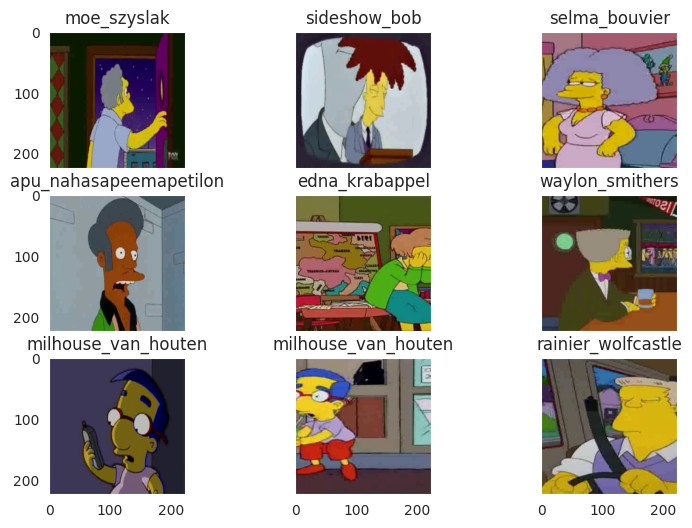

In [ ]:
random_imgs = random.choices(datasets['train'], k=9)

plot_random_images(random_imgs)

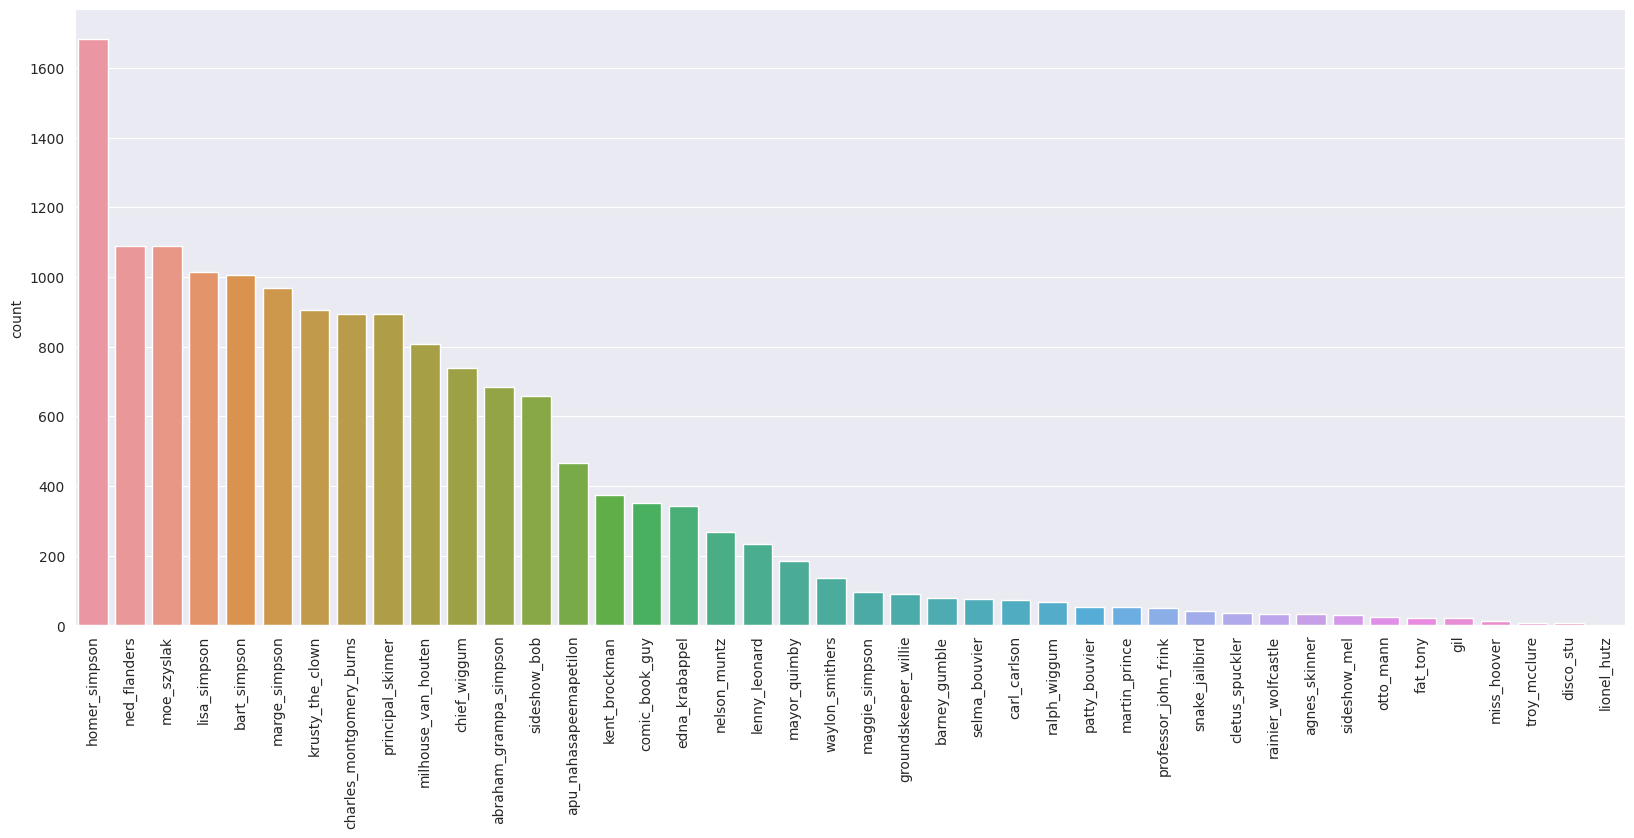

In [ ]:
train_labels = [path.parent.name for path in train_files]
c = Counter(train_labels)

plt.figure(figsize=(20,8))
ax = sns.countplot(x=train_labels, order=[item[0] for item in c.most_common()], orient='v')
ax.tick_params(axis='x', rotation=90)

Реализуем цикл обучения

In [ ]:
def fit_model(model, criterion, optimizer, sheduler, n_epochs):
    model.to(DEVICE)

    losses = {"train": [], "val": []}
    acc = {"train": [], "val": []}

    best_acc = 0
    best_model_state = None

    for epoch_num in trange(n_epochs, desc="Epoch:"):
        since = time.time()

        print('Epoch {}/{}'.format(epoch_num, n_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            epoch_loss = 0
            epoch_acc = 0

            for batch, labels in loaders[phase]:
                batch = batch.to(DEVICE)
                labels = labels.to(DEVICE)

                if phase == 'train':
                    model.train()
                    model.zero_grad()
                    outp = model(batch)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                elif phase == "val":
                    model.eval()
                    with torch.no_grad():
                        outp = model(batch.cuda())
                        loss = criterion(outp, labels)

                epoch_loss += loss.item()/len(datasets[phase])
                y_pred = torch.argmax(outp, -1)
                epoch_acc += int(torch.sum(y_pred == labels).cpu())/len(datasets[phase])

            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_state = copy.deepcopy(model.state_dict())
                print('{} Val loss: {:.4f} Val acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        sheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_state)

    return model, (losses, acc)

In [ ]:
def predict(model, dataloader):
    model.to(DEVICE)
    pred_labels = torch.IntTensor().cpu()
    true_labels = torch.IntTensor().cpu()
    model.eval()
    for item in dataloader:
        if len(item) > 1:
            true_labels = torch.cat([true_labels, item[1].cpu()], dim=0)
            batch = item[0].to(DEVICE)
        else:
            batch = item[0].to(DEVICE)

        with torch.no_grad():
            outp = model(batch)
            y_pred = torch.argmax(outp, -1)

        pred_labels = torch.cat([pred_labels, y_pred.cpu()], dim=0)
    return pred_labels, true_labels

In [ ]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy = {acc}")

    f1_scores = f1_score(y_true, y_pred, average=None)
    df_dict = {"label": [],
               "f1-score": [],
               "count": []}

    for l, f1 in enumerate(f1_scores):
        df_dict['label'].extend(LE.inverse_transform([l]))
        df_dict['f1-score'].append(f1)
        df_dict['count'].append(np.sum(y_true.numpy() == l))

    df_info = pd.DataFrame(df_dict)
    return df_info.sort_values(by='f1-score', ascending=False)

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 42)


criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, metrics = fit_model(model, criterion, optimizer_ft, exp_lr_scheduler, 20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


Epoch::   5%|▌         | 1/20 [01:39<31:37, 99.86s/it]

val Val loss: 0.0231 Val acc: 0.8082
Epoch 1/19
----------


Epoch::  10%|█         | 2/20 [03:13<28:50, 96.12s/it]

val Val loss: 0.0115 Val acc: 0.9089
Epoch 2/19
----------


Epoch::  15%|█▌        | 3/20 [04:45<26:46, 94.51s/it]

val Val loss: 0.0093 Val acc: 0.9270
Epoch 3/19
----------


Epoch::  20%|██        | 4/20 [06:18<24:57, 93.60s/it]

val Val loss: 0.0086 Val acc: 0.9362
Epoch 4/19
----------


Epoch::  25%|██▌       | 5/20 [07:50<23:14, 93.00s/it]

Epoch 5/19
----------


Epoch::  30%|███       | 6/20 [09:22<21:37, 92.71s/it]

val Val loss: 0.0077 Val acc: 0.9448
Epoch 6/19
----------


Epoch::  35%|███▌      | 7/20 [10:53<19:59, 92.26s/it]

Epoch 7/19
----------


Epoch::  40%|████      | 8/20 [12:27<18:31, 92.66s/it]

val Val loss: 0.0049 Val acc: 0.9692
Epoch 8/19
----------


Epoch::  45%|████▌     | 9/20 [13:59<16:56, 92.44s/it]

val Val loss: 0.0049 Val acc: 0.9721
Epoch 9/19
----------


Epoch::  50%|█████     | 10/20 [15:31<15:23, 92.31s/it]

Epoch 10/19
----------


Epoch::  55%|█████▌    | 11/20 [17:02<13:49, 92.18s/it]

val Val loss: 0.0047 Val acc: 0.9729
Epoch 11/19
----------


Epoch::  60%|██████    | 12/20 [18:34<12:15, 91.96s/it]

Epoch 12/19
----------


Epoch::  65%|██████▌   | 13/20 [20:06<10:44, 92.11s/it]

Epoch 13/19
----------


Epoch::  70%|███████   | 14/20 [21:41<09:17, 92.93s/it]

val Val loss: 0.0050 Val acc: 0.9731
Epoch 14/19
----------


Epoch::  75%|███████▌  | 15/20 [23:16<07:47, 93.44s/it]

Epoch 15/19
----------


Epoch::  80%|████████  | 16/20 [24:48<06:12, 93.04s/it]

val Val loss: 0.0049 Val acc: 0.9734
Epoch 16/19
----------


Epoch::  85%|████████▌ | 17/20 [26:20<04:37, 92.63s/it]

val Val loss: 0.0049 Val acc: 0.9738
Epoch 17/19
----------


Epoch::  90%|█████████ | 18/20 [27:52<03:04, 92.46s/it]

val Val loss: 0.0049 Val acc: 0.9755
Epoch 18/19
----------


Epoch::  95%|█████████▌| 19/20 [29:23<01:32, 92.16s/it]

Epoch 19/19
----------


Epoch:: 100%|██████████| 20/20 [30:58<00:00, 92.92s/it]

Training complete in 1m 35s
Best val Acc: 0.975545


In [ ]:
y_pred, y_true = predict(model, loaders['val'])

metrics_df = compute_metrics(y_true, y_pred)
metrics_df

Accuracy = 0.9755445166220864


,label,f1-score,count
26,miss_hoover,1.000000,4
19,lionel_hutz,1.000000,1
40,troy_mcclure,1.000000,2
12,fat_tony,1.000000,7
22,marge_simpson,0.992320,323
4,bart_simpson,0.989599,336
17,krusty_the_clown,0.988391,302
2,apu_nahasapeemapetilon,0.987097,156
25,milhouse_van_houten,0.985019,270
37,sideshow_bob,0.984199,219


In [ ]:
f1_score(y_true, y_pred, average="macro")

0.9324778495258247